# Active Damping for 6-DOF Active Vibration Isolation System (Non-Collocated Configuration)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tatsuki-washimi/gwexpy/blob/main/docs/web/en/user_guide/tutorials/case_active_damping.ipynb)

This tutorial demonstrates an end-to-end workflow combining `gwexpy` and `python-control` to perform simulation, system identification, and control design for a multi-degree-of-freedom (MIMO) system.

**Scenario:**
We consider an equilateral triangular vibration isolation platform supported by three legs (6-DOF rigid body).
In this case, we deal with a **non-collocated configuration where actuators and sensors are located at different positions**.
*   **Actuators**: Located at the three leg positions (support points) at $0^\circ, 120^\circ, 240^\circ$
*   **Sensors**: Located at mid-points between the legs at $60^\circ, 180^\circ, 300^\circ$

When the input/output positions are misaligned like this, simple independent control for each axis does not work well. Therefore, we perform controller design in **Modal Space**.

**Steps:**
1.  **Physical Model Construction**: Create a state-space model considering sensor and actuator placement.
2.  **MIMO Transfer Function Measurement**: Visualize the transfer function matrix including off-diagonal components using `FrequencySeriesMatrix`.
3.  **System Identification**: Define a control model from physical parameters and geometric configuration.
4.  **Damping Controller Design**: Design "modal control" that converts sensor signals to modal coordinates and applies damping to each mode.
5.  **Closed-Loop Verification**: Confirm vibration suppression performance through impulse response and ASD comparison.

In [1]:
import control
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from gwexpy import TimeSeries, TimeSeriesDict
from gwexpy.frequencyseries import FrequencySeriesMatrix

## 1. Simulation of 6-DOF Active Vibration Isolation System (Plant Model)

We define the rigid body equation of motion $M \ddot{q} + C \dot{q} + K q = F$.
Here we focus on the three vertical degrees of freedom ($z, \theta_x, \theta_y$).

**Coordinate Transformation:**
For modal coordinates $q = [z, \theta_x, \theta_y]^T$,
*   Actuator physical coordinates $p_{act}$: $0^\circ, 120^\circ, 240^\circ$
*   Sensor physical coordinates $p_{sen}$: $60^\circ, 180^\circ, 300^\circ$

We define the transformation matrices $T_{act}, T_{sen}$ for each and incorporate them into the state-space model.

In [2]:
# Physical parameters
m = 100.0  # mass [kg]
I_x = 20.0  # moment of inertia [kg m^2]
I_y = 20.0

# Support spring and damper (actuator position = leg position)
k_leg = 2000.0  # spring constant [N/m]
c_leg = 0.20  # damping coefficient [N s/m]

# Geometry: radius R
R = 0.5  # [m]

# Angle settings (deg -> rad)
deg2rad = np.pi / 180.0
# Actuators: leg positions
angles_act = np.array([0, 120, 240]) * deg2rad
# Sensors: between legs
angles_sen = np.array([60, 180, 300]) * deg2rad


# Function to create coordinate transformation matrix
# p = T * q  =>  [z_i] = [1, R*sin(th), -R*cos(th)] @ [z, tx, ty]
def make_transform_matrix(angles, radius):
    T = np.zeros((3, 3))
    for i, ang in enumerate(angles):
        T[i, 0] = 1.0
        T[i, 1] = radius * np.sin(ang)
        T[i, 2] = -radius * np.cos(ang)
    return T


T_act = make_transform_matrix(angles_act, R)
T_sen = make_transform_matrix(angles_sen, R)

print("Actuator Transform Matrix T_act:")
print(np.round(T_act, 2))
print("Sensor Transform Matrix T_sen:")
print(np.round(T_sen, 2))

# M, K, C matrices in modal space
M_modal = np.diag([m, I_x, I_y])

# K, C in physical space (leg position)
K_phys = np.diag([k_leg, k_leg, k_leg])
C_phys = np.diag([c_leg, c_leg, c_leg])

# Project to modal space: K_modal = T_act.T * K_phys * T_act
# (Spring and damper are at leg positions, so use T_act)
K_modal = T_act.T @ K_phys @ T_act
C_modal = T_act.T @ C_phys @ T_act

# Create state-space model
# x = [q, q_dot]^T
A_sys = np.block(
    [
        [np.zeros((3, 3)), np.eye(3)],
        [-np.linalg.inv(M_modal) @ K_modal, -np.linalg.inv(M_modal) @ C_modal],
    ]
)
B_sys_modal = np.block([[np.zeros((3, 3))], [np.linalg.inv(M_modal)]])
C_sys_modal = np.block([np.eye(3), np.zeros((3, 3))])
D_sys = np.zeros((3, 3))

# Convert input/output to physical coordinates
# Input: Actuator Forces u (at angles_act) -> Generalized Force Q = T_act.T * u
# Output: Sensor Displacements y (at angles_sen) -> y = T_sen * q
B_sys = B_sys_modal @ T_act.T
C_sys = T_sen @ C_sys_modal

sys = control.StateSpace(
    A_sys,
    B_sys,
    C_sys,
    D_sys,
    inputs=["ACT1", "ACT2", "ACT3"],
    outputs=["SEN1", "SEN2", "SEN3"],
)
print(sys)

Actuator Transform Matrix T_act:
[[ 1.    0.   -0.5 ]
 [ 1.    0.43  0.25]
 [ 1.   -0.43  0.25]]
Sensor Transform Matrix T_sen:
[[ 1.    0.43 -0.25]
 [ 1.    0.    0.5 ]
 [ 1.   -0.43 -0.25]]
<StateSpace>: sys[0]
Inputs (3): ['ACT1', 'ACT2', 'ACT3']
Outputs (3): ['SEN1', 'SEN2', 'SEN3']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00
       1.00000000e+00  0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00
       0.00000000e+00  1.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00
       0.00000000e+00  0.00000000e+00  1.00000000e+00]
     [-6.00000000e+01 -3.33955086e-15 -2.16715534e-15
      -6.00000000e-03 -3.68259567e-19 -2.35922393e-19]
     [-1.70530257e-14 -3.75000000e+01  9.61481343e-15
      -2.08166817e-18 -3.75000000e-03  9.61481343e-19]
     [-1.13686838e-14  9.93438680e-15 -3.75000000e+01
      -1.04083409e-18  9.61481343e-19 -3.75000000e-

## 2. MIMO Transfer Function Measurement

Since the sensor and actuator positions differ, strong responses should appear not only in the diagonal components (ACT1->SEN1) but also in the off-diagonal components.

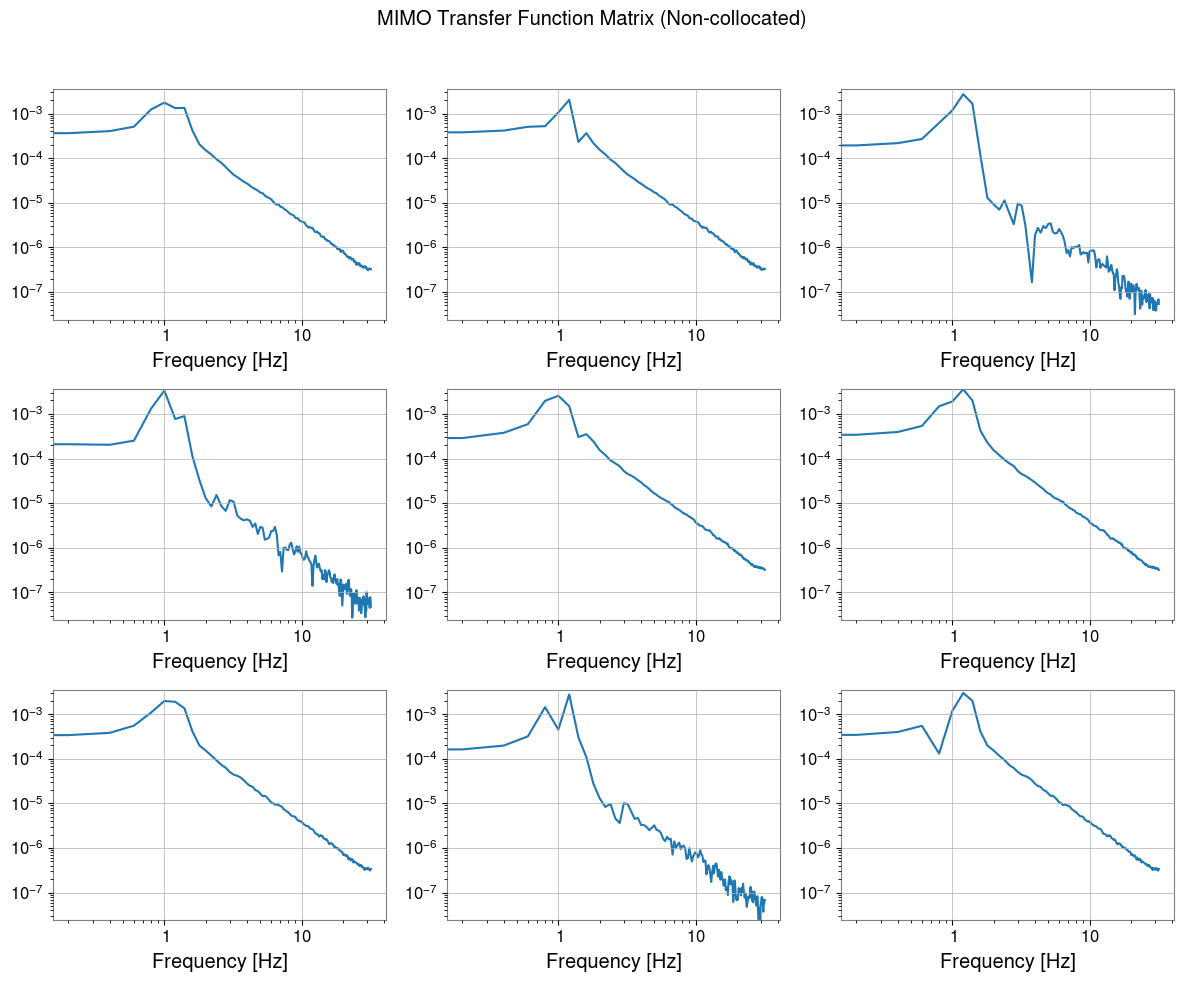

In [3]:
fs = 64
duration = 1024.0
t = np.arange(0, duration, 1 / fs)
n_samples = len(t)

# Input signal: 3ch white noise
np.random.seed(0)
u_data = np.random.normal(0, 1.0, (3, n_samples))

# Time response
time_response = control.forced_response(sys, T=t, U=u_data)

# gwexpy TimeSeriesDict
tsd_input = TimeSeriesDict(
    {
        f"ACT{i + 1}": TimeSeries(
            u_data[i], t0=0, sample_rate=fs, name=f"Actuator {i + 1}", unit="N"
        )
        for i in range(3)
    }
)

tsd_output = TimeSeriesDict.from_control(time_response, unit="m")
for i in range(3):
    tsd_output[f"SEN{i + 1}"].name = f"Sensor {i + 1}"

# MIMO TF calculation
tfs = [
    [
        tsd_input[f"ACT{j + 1}"].transfer_function(
            tsd_output[f"SEN{i + 1}"], fftlength=5
        )
        for j in range(3)
    ]
    for i in range(3)
]

tf_matrix = FrequencySeriesMatrix(
    [[tf.value for tf in row] for row in tfs], frequencies=tfs[0][0].frequencies
)

tf_data = tf_matrix.value
freqs = tf_matrix.frequencies

# plot
tf_matrix.abs().plot(figsize=(12, 10), xscale="log", yscale="log").suptitle(
    "MIMO Transfer Function Matrix (Non-collocated)\n\n"
)
plt.tight_layout()
plt.show()

## 3 & 4. Modal Control Design

Since the actuator and sensor positions do not coincide, simple decentralized control ($F_i \propto \dot{y}_i$) may become unstable.
Therefore, we adopt a method that **estimates modal displacement from sensor signals using transformation matrices, applies damping in modal space, and then distributes the result to actuator forces**.

**Control Flow:**
1.  **Sensing**: Estimate modal displacement $q$ from sensor output $y$
    $$ q_{est} = T_{sen}^{-1} y $$
2.  **Modal Damping**: Apply pseudo-derivative filter $K(s)$ to each mode to calculate modal force $F_{modal}$
    $$ F_{modal} = -K_{modal}(s) q_{est} $$
3.  **Actuation**: Distribute modal force $F_{modal}$ to actuator forces $u$
    $$ u = (T_{act}^T)^{-1} F_{modal} $$

Overall, the MIMO controller $K_{MIMO}$ becomes:
$$ K_{MIMO}(s) = (T_{act}^T)^{-1} \cdot \mathrm{diag}(K_{z}(s), K_{\theta x}(s), K_{\theta y}(s)) \cdot T_{sen}^{-1} $$

In [4]:
# --- 1. Preparation of Sensing & Actuation Matrices ---
# Prepare transformation matrices based on the estimated model (here we use the true values)
# Sensing Matrix: y -> q
S_sensing = np.linalg.inv(T_sen)

# Actuation Matrix: F_modal -> u
# F_modal = T_act.T * u  =>  u = inv(T_act.T) * F_modal
D_actuation = np.linalg.inv(T_act.T)

print("Sensing Matrix (Sensor -> Mode):")
print(np.round(S_sensing, 2))
print("Actuation Matrix (Mode Force -> Actuator):")
print(np.round(D_actuation, 2))

# --- 2. Modal Damping Filter Design ---
# Set damping gain for each mode
# It is possible to use different gains for translation mode (z) and rotation modes (tx, ty),
# but for simplicity, we use the same gain and filter for all modes.
gain = 1000.0  # Modal Damping Gain
fc_l = 0.1
fc_h = 20.0
w_l = 2 * np.pi * fc_l
w_h = 2 * np.pi * fc_h

s = control.tf("s")
K_filter = gain * s / ((1 + s / w_l) * (1 + s / w_h))

# Create diagonal matrix (for 3 modes)
K_modal_diag = []
for _ in range(3):
    K_modal_diag.append(control.ss(K_filter))

# control.append performs diagonal block combination, but care is needed as the number of inputs/outputs changes.
# Rather than manually combining state-space models,
# we construct K_MIMO using python-control's calculation capabilities.

# K_modal_block: 3-input 3-output Diagonal System
#  [ K_f  0    0   ]
#  [ 0    K_f  0   ]
#  [ 0    0    K_f ]
K_modal_block = control.append(K_modal_diag[0], K_modal_diag[1], K_modal_diag[2])


# --- 3. MIMO Controller Construction ---
# K_MIMO = D_actuation * K_modal_block * S_sensing
# In python-control, the product of constant matrices and SS can be written directly

# S_sensing (Static Gain) * y
# K_modal_block * (S_sensing * y)
# D_actuation * (K_modal_block * S_sensing * y)

# Note: Pay attention to the order of matrix multiplication. Multiplication of Control objects is series connection.
# Sys2 * Sys1 is Out <--- Sys2 <--- Sys1 <--- In
# Formula: u = D * K * S * y
# Code: K_mimo = D * K * S
# However, D and S are numpy arrays. Conversion to control.ss(D) etc. is needed.

K_mimo = D_actuation * K_modal_block * S_sensing

print("MIMO Controller States:", K_mimo.nstates)

Sensing Matrix (Sensor -> Mode):
[[ 0.33  0.33  0.33]
 [ 1.15 -0.   -1.15]
 [-0.67  1.33 -0.67]]
Actuation Matrix (Mode Force -> Actuator):
[[ 0.33 -0.   -1.33]
 [ 0.33  1.15  0.67]
 [ 0.33 -1.15  0.67]]
MIMO Controller States: 6


## 5 & 6. Closed-Loop Verification (Impulse Response & ASD)

Using the constructed modal control system, we perform closed-loop simulation.
We verify the response to an impulse disturbance on actuator 1 and to steady-state ground vibration on all axes.

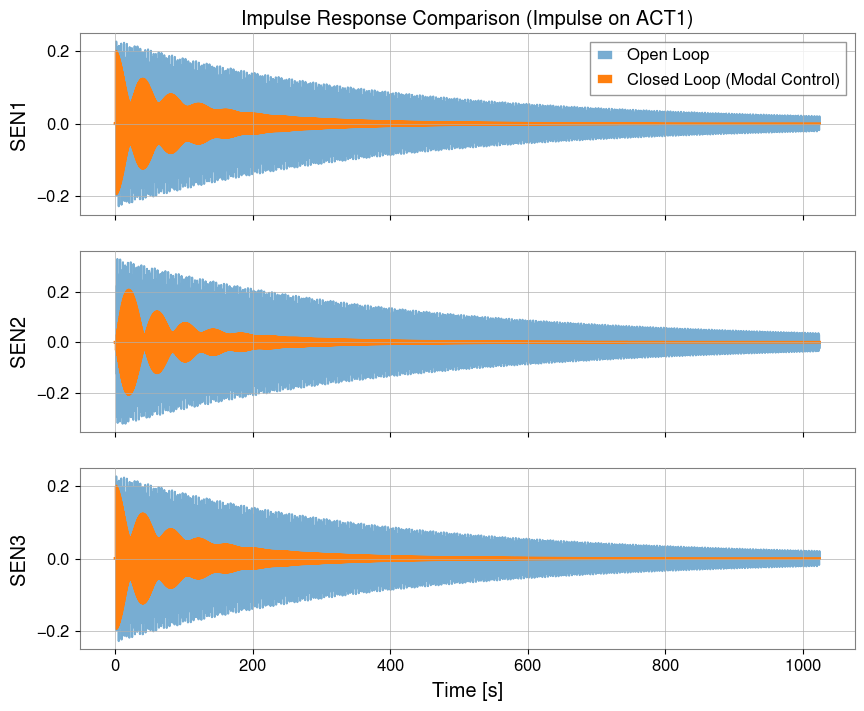

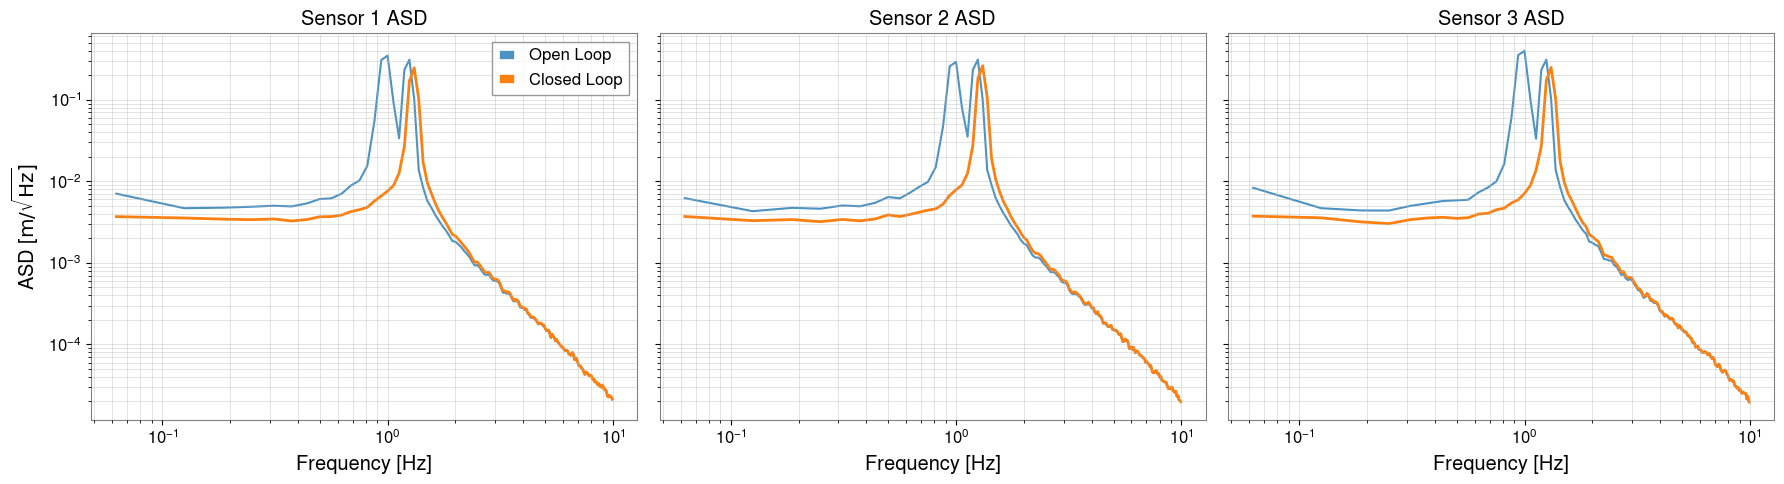

In [5]:
# Closed-loop system
sys_cl = control.feedback(sys, K_mimo, sign=-1)

# --- Impulse Response ---
u_impulse = np.zeros((3, n_samples))
u_impulse[0, 100] = 100.0 * fs  # Impulse on Actuator 1

resp_ol = control.forced_response(sys, T=t, U=u_impulse)
resp_cl = control.forced_response(sys_cl, T=t, U=u_impulse)

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(3):
    ax = axes[i]
    ax.plot(t, resp_ol.outputs[i], label="Open Loop", alpha=0.6)
    ax.plot(t, resp_cl.outputs[i], label="Closed Loop (Modal Control)", linewidth=2)
    ax.set_ylabel(f"SEN{i + 1}")
    ax.grid(True)
    if i == 0:
        ax.legend(loc="upper right")
axes[2].set_xlabel("Time [s]")
axes[0].set_title("Impulse Response Comparison (Impulse on ACT1)")
plt.show()

# --- ASD Comparison ---
# Ground Vibration Simulation
np.random.seed(42)
wn = np.random.normal(0, 1.0, (3, n_samples))
b, a = signal.butter(1, 5.0, fs=fs, btype="low")
dist = signal.lfilter(b, a, wn) * 50.0

resp_ol_noise = control.forced_response(sys, T=t, U=dist)
resp_cl_noise = control.forced_response(sys_cl, T=t, U=dist)

tsd_ol = TimeSeriesDict.from_control(resp_ol_noise)
for i in range(3):
    tsd_ol[list(tsd_ol.keys())[i]].name = f"SEN{i + 1}"
tsd_ol = TimeSeriesDict({ts.name: ts for ts in tsd_ol.values()})
tsd_cl = TimeSeriesDict.from_control(resp_cl_noise)
for i in range(3):
    tsd_cl[list(tsd_cl.keys())[i]].name = f"SEN{i + 1}"
tsd_cl = TimeSeriesDict({ts.name: ts for ts in tsd_cl.values()})

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i in range(3):
    ax = axes[i]
    asd_ol = (
        tsd_ol[f"SEN{i + 1}"].asd(fftlength=16, overlap=8, method="welch").crop(0.1, 10)
    )
    asd_cl = (
        tsd_cl[f"SEN{i + 1}"].asd(fftlength=16, overlap=8, method="welch").crop(0.1, 10)
    )

    ax.loglog(asd_ol, label="Open Loop", alpha=0.8)
    ax.loglog(asd_cl, label="Closed Loop", linewidth=2)
    ax.set_title(f"Sensor {i + 1} ASD")
    ax.set_xlabel("Frequency [Hz]")
    ax.grid(True, which="both", alpha=0.5)
    if i == 0:
        ax.set_ylabel(r"ASD [$\mathrm{m}/\sqrt{\mathrm{Hz}}$]")
        ax.legend()
plt.tight_layout()
plt.show()

# Even when sensor and actuator positions are different,
# effective damping is achieved through appropriate modal coordinate transformation.